# Fixed-point attractor solution to the M3A task
This notebook trains a CT-RNN on the Modulo 3 Arithmetic task and visualizes the learned dynamics of the network. The learn dynamics should be a network of fixed-point attractors where integer stimuli are encoded as vector impuluses.

## Imports

In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax import random
from flax import linen as nn

from ctrnn_jax.model import CTRNNCell
from ctrnn_jax.training import (
create_train_state, 
ModelParameters,
)
from ctrnn_jax.analyses import compute_pca

from recurrent_networks_oscillate.task import Modulo3Arithmetic
from recurrent_networks_oscillate.training import (
create_train_state,
train_step,
compute_metrics,
)

In [2]:
key = random.PRNGKey(420)

## Configure parameters

In [3]:
# Task parameters
TIME_LENGTH = 50
MIN_SAMPLES = 50
TEST_SAMPLES = 1

In [4]:
# Model parameters
HIDDEN_NEURONS = 100
OUTPUT_NEURONS = 1
ALPHA = jnp.float32(0.1)
NOISE_SCALAR = jnp.float32(0.1)

In [5]:
# Training parameters
BATCH_SIZE = 128
LEARNING_RATE = 0.001
NORM_CLIP = 1.0
INIT_ARRAY = jnp.ones([1, 50, 100])
EPOCHS = 100

## Initialize `Modulo3Arithmetic` task

In [6]:
# Initialize task
key, task_key = random.split(key, num=2)
task = Modulo3Arithmetic(
    task_key, 
    neurons=HIDDEN_NEURONS,
    time=TIME_LENGTH,
    min_training_trials=MIN_SAMPLES,
    testing_trials=TEST_SAMPLES,
)

In [7]:
# Initialize TensorFlow datasets
tf_train, tf_test = task.tf_datasets(TEST_SAMPLES,)

In [8]:
# Initialize training batches
test_batch = [batch for batch in tf_test.as_numpy_iterator()][0]

In [9]:
# Print training and testing information
task.print_training_testing()


TRAINING DATA

Accepting Grid:
Integer Sequence | Number of Trials
000 | 100
012 | 100
021 | 100
102 | 100
111 | 100
120 | 100
201 | 100
210 | 100
222 | 100

Rejecting Grid:
Integer Sequence | Number of Trials
001 | 50
002 | 50
010 | 50
011 | 50
020 | 50
022 | 50
100 | 50
101 | 50
110 | 50
112 | 50
121 | 50
122 | 50
200 | 50
202 | 50
211 | 50
212 | 50
220 | 50
221 | 50

----------

TESTING DATA

Accepting Grid:
Integer Sequence | Number of Trials
000 | 1
012 | 1
021 | 1
102 | 1
111 | 1
120 | 1
201 | 1
210 | 1
222 | 1

Rejecting Grid:
Integer Sequence | Number of Trials
001 | 1
002 | 1
010 | 1
011 | 1
020 | 1
022 | 1
100 | 1
101 | 1
110 | 1
112 | 1
121 | 1
122 | 1
200 | 1
202 | 1
211 | 1
212 | 1
220 | 1
221 | 1




## Initialize CT-RNN

In [10]:
# Initialize model
ctrnn = nn.RNN(
    CTRNNCell(
        hidden_features=HIDDEN_NEURONS,
        output_features=OUTPUT_NEURONS,
        alpha=ALPHA, 
        noise_const=NOISE_SCALAR,
    ), 
    split_rngs={'params': False, 'noise_stream': True}
)

In [11]:
# Initialize train state
key, train_state_key = random.split(key, num=2)
train_state = create_train_state(
    train_state_key, 
    ctrnn, 
    LEARNING_RATE, 
    NORM_CLIP, 
    INIT_ARRAY,
)

## Train CT-RNN on the `Modulo3Arithmetic` task

In [12]:
# Initalize metrics
metrics_history = {
    'train_loss': [], 
    'train_accuracy': [], 
    'test_loss': [], 
    'test_accuracy': [], 
}

In [13]:
# Initialize tracking for the lowest testing loss
best_test_loss = float('inf')
best_test_params = None
best_test_epoch = None

In [14]:
# Train model
for epoch in tqdm(range(EPOCHS)):

    # Perform backpropagation
    for _, batch in enumerate(tf_train.as_numpy_iterator()):
        key, train_key, metrics_key = random.split(key, num=3)
        train_state = train_step(
            train_key, 
            train_state, 
            batch, 
        )
        train_state = compute_metrics(
            metrics_key, 
            train_state, 
            batch,
        )

    # Compute and store training metrics
    for metric, value in train_state.metrics.compute().items():
        metrics_history[f'train_{metric}'].append(value.item())
        
    # Clear metrics
    train_state = train_state.replace(metrics=train_state.metrics.empty())

    # Compute and store testing metrics
    key, test_key = random.split(key, num=2)
    test_state = train_state
    test_state = compute_metrics(test_key, test_state, test_batch)
    for metric, value in test_state.metrics.compute().items():
        if metric == 'loss':
            test_loss = value.item()
        metrics_history[f'test_{metric}'].append(value.item())

    
    # Update the best train state if the current test loss is the lowest
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        best_test_params = ModelParameters(train_state)
        best_test_epoch = epoch

100%|███████████████████████████████████████████████████████████████████████| 100/100 [05:21<00:00,  3.22s/it]


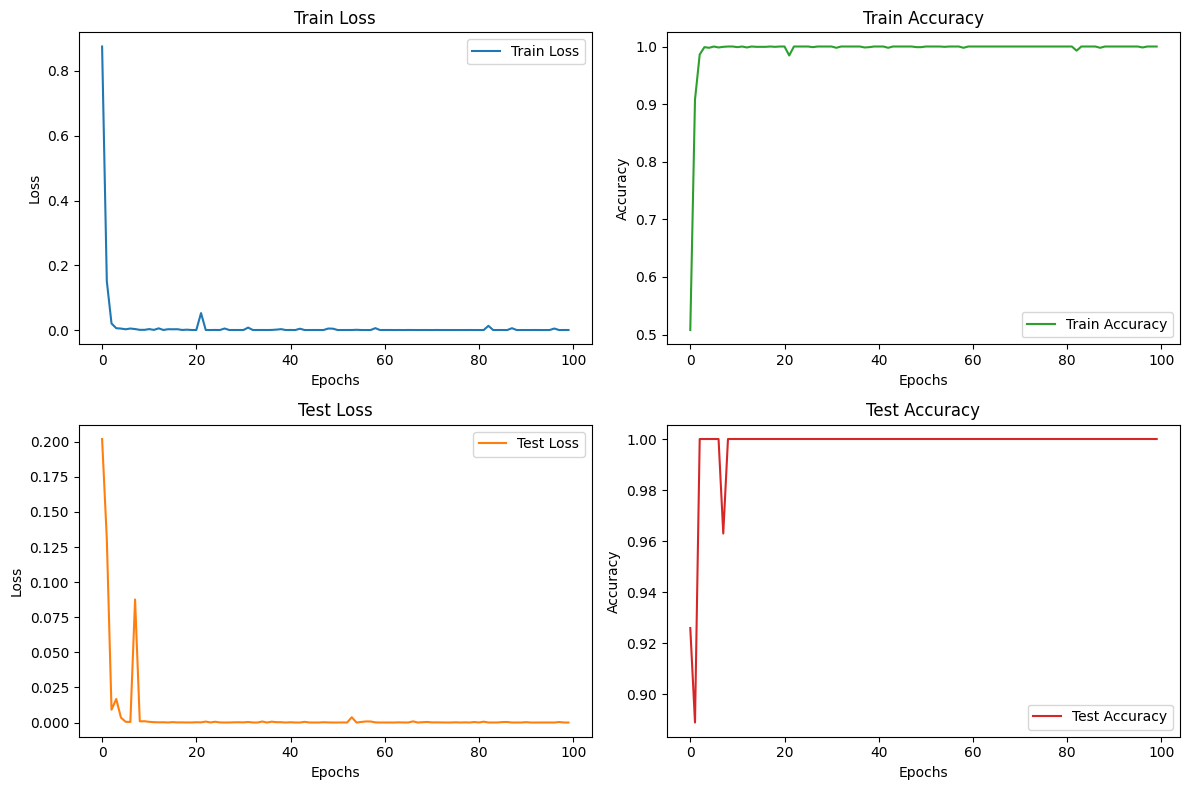

In [15]:
# Create a 2x2 grid for the subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Panel 1: Train Loss
axs[0, 0].plot(metrics_history['train_loss'], label='Train Loss', color='tab:blue')
axs[0, 0].set_title('Train Loss')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].legend()

# Panel 2: Train Accuracy
axs[0, 1].plot(metrics_history['train_accuracy'], label='Train Accuracy', color='tab:green')
axs[0, 1].set_title('Train Accuracy')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].legend()

# Panel 3: Test Loss
axs[1, 0].plot(metrics_history['test_loss'], label='Test Loss', color='tab:orange')
axs[1, 0].set_title('Test Loss')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].legend()

# Panel 4: Test Accuracy
axs[1, 1].plot(metrics_history['test_accuracy'], label='Test Accuracy', color='tab:red')
axs[1, 1].set_title('Test Accuracy')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

In [16]:
print(f'Best accuracy epoch of {best_test_epoch}')

Best accuracy epoch of 99


## PCA of CT-RNN activity

In [17]:
# Compute PCA
key, pca_key = random.split(key, num=2)
model_behavior, pca = compute_pca(
    pca_key,
    train_state,
    best_test_params.params,
    tf_test,
    2,
)

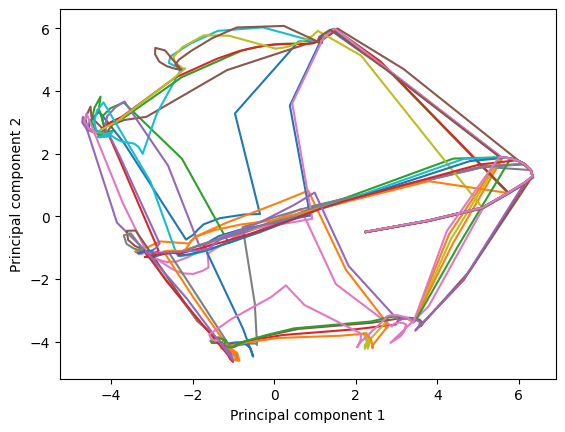

In [18]:
# Plot PCA activity for Principal Components 1 and 2
for i in range(model_behavior['rates_pc'].shape[0]):
    plt.plot(
        model_behavior['rates_pc'][i, :, 0], 
        model_behavior['rates_pc'][i, :, 1], 
    )
    if i > 50:
        break

plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.show()